In [1]:
# How do I increase the cell width of the Jupyter/ipython notebook in my browser? https://stackoverflow.com/a/34058270
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

from datetime import date,datetime
dateStamp = date.today().strftime("%y%m%d")

np.random.seed(0)

### Steps: goal: characterize the match score between poses & stereotypic pattern 

**data input** 
    
    read_individualRating_from_condition(scenarioAlone)
    
**common across analyses**
    
    represent_pose_with_ActionUnit_pattern
    compute_median_ratings
    
    compute_mean_estimates_and_CI

**reliability analysis**

    assign_stereotypicEmotionCategory_to_each_scenario ~ retrieveHighestRatedEmotionCategoryForEachScenario
        define_assignment_criteria
            emotionCategory_with_highest_median_rating 
                break_tie_basedOn_narrower_interquartileRange 
                    implementation:
                        ~ intermediate step: compute JointProxyWhereHighestRatedCategoryIsMinimumValue = dfMedianProxy+dfIQR
                        ~ extractCategoryWithHighestMedianSmallestIQR

    compare_between_each_pose_and_stereotypicPattern_using_matchScore 
        define_comparison_metric
        compute_matchScore_using_defined_metric
        
    
    +characterize_matchScore_using_statisticalMethods        

**specificity_analysis** 

    represent_pose_with_ActionUnit_pattern ~ dfAU_binaryActivation=obtainActionUnitActivationDataframeBasedOn(df_original,ACTIVATION_THRESHOLD)  
    
    assign_poses_into_emotion_category_by_AUstereotypes
        pick_matching_poses_forEach_AUstereotypes_variants 
            compute_match_score_for_all_poses_against_a_variant
            pick_poses_with_score_above_specificityThreshold
        combine_matching_poses_across_variants_of_AU_stereotypes
        retain_unique_set_of_matching_poses_by_removing_overlaps
        
    determine_if_pose_specific_to_assignged_emotion_category
        is_pose_NOT_specific_to_assigned_emotion_category
            is_rating_of_assigned_emotion_category_BELOW_presenceThreshold
            is_rating_of_another_emotion_category_ATLEAST_presenseThreshold    
        
    compute_false_positive_rate_for_each_emotion_category
        count_total_poses_assigned_to_emotion_category
        count_false_positive_poses_per_assigned_to_emotion_category
        false_positive = count_false_positive_poses_per_assigned_to_emotion_category/ count_total_poses_assigned_to_emotion_category
      

In [3]:
### MAIN ###

In [4]:
class Matcher():
    def __init__(self,AU_PATTERN_FILE='refAU_13_ekman_plusICPonly'):
            ### MAIN ###
        self.compute_match = {
            'method1' : self.compute_match_score_method1,
            'method2' : self.compute_match_score_method2,
            'method1_sim_addAU' : self.compute_match_score_method1_simulate_additionalAU_baseline_median,
            'method2_sim_addAU' : self.compute_match_score_method2_simulate_additionalAU_baseline_median,
            'method1_allAddAU': self.compute_match_score_method1_additionalAU_alwaysOn,
            'method2_allAddAU': self.compute_match_score_method2_additionalAU_alwaysOn,
            'method1_sim_addAU_baseline_max' : self.compute_match_score_method1_simulate_additionalAU_baseline_max,
            'method2_sim_addAU_baseline_max' : self.compute_match_score_method2_simulate_additionalAU_baseline_max,
        }

        from facsStereotypes import AUdataReadWrite
        rw=AUdataReadWrite()
        self.STEREOTYPES = rw.load_AUdata_into_currentFormat(AU_PATTERN_FILE)
        
        self.compute_matchScore_across_stereotypeVariants={
            'median': self.compute_median_matchScore_across_stereotypeVariants,
            'max' : self.compute_max_matchScore_across_stereotypeVariants,
            'median-cordaro': self.compute_median_matchScore_across_stereotypeVariants_addCordaroUSA,
        }

    @staticmethod
    def compute_match_score_method1(target,ref,v=False): 
        ''' #method 1 - coderReliabilityMethod: jointly activated AU x 2 / all activated AU across target & reference pattern '''
        print('method1') if(v) else ''
        try:
            return len(set(target).intersection(set(ref)))*2/(len(target)+len(ref))   
        except:
            return 1 # fully matched - neutral

    @staticmethod
    def compute_match_score_method2(target,ref,v=False): 
        ''' #method 2 - directMatchMethod: overlapped activated AU / activated AU of reference pattern '''
        print('method2') if(v) else ''
        return len(set(target).intersection(set(ref)))/len(ref)


    ### CONSIDERING ADDITION AU ###
    @staticmethod
    def get_number_of_AUs_above_27(ref): AU27vec=[i for i in ref if i <=27];return len(ref)-len(AU27vec)
    
    def compute_match_score_method1_simulate_additionalAU_baseline_median(self,target,ref,v=False,AU_BASELINE=.104):
        return self.compute_match_score_method1_simulate_additionalAU(target,ref,v=False,AU_BASELINE=AU_BASELINE)
    
    def compute_match_score_method2_simulate_additionalAU_baseline_median(self,target,ref,v=False,AU_BASELINE=.104):
        return self.compute_match_score_method2_simulate_additionalAU(target,ref,AU_BASELINE=AU_BASELINE,v=False)
    
    def compute_match_score_method1_simulate_additionalAU_baseline_max(self,target,ref,v=False,AU_BASELINE=.651):
        return self.compute_match_score_method1_simulate_additionalAU(target,ref,v=False,AU_BASELINE=AU_BASELINE)
    
    def compute_match_score_method2_simulate_additionalAU_baseline_max(self,target,ref,v=False,AU_BASELINE=.651):
        return self.compute_match_score_method2_simulate_additionalAU(target,ref,v=False,AU_BASELINE=AU_BASELINE)

    def compute_match_score_method1_simulate_additionalAU(self,target,ref,AU_BASELINE,v=False):
        ''' #method 1, simulate activated AU above 27 (1000 simulations), randomly assigned whether AU above 27 within stereotype pattern is activated in target pattern'''
        n27=self.get_number_of_AUs_above_27(ref)

        def randomize_number_of_AUoverlap_above_AU27(totalAUabove27,AU_BASELINE): 
            return np.sum(np.random.rand(1000,totalAUabove27)<AU_BASELINE,axis=1)
        o27Arr= randomize_number_of_AUoverlap_above_AU27(n27,AU_BASELINE)

        def computeMatch(n): return (len(set(target).intersection(set(ref)))*2+n*2)/(len(target)+len(ref)+n+n27)    
        ms= [computeMatch(n) for n in o27Arr]

        return np.median(ms)

    def compute_match_score_method2_simulate_additionalAU(self,target,ref,AU_BASELINE,v=False):
        ''' #method 2, simulate activated AU above 27 (1000 simulations), randomly assigned whether AU above 27 within stereotype pattern is activated in target pattern '''
        n27=self.get_number_of_AUs_above_27(ref)

        def randomize_number_of_AUoverlap_above_AU27(totalAUabove27,AU_BASELINE = AU_BASELINE): 
            return np.sum(np.random.rand(1000,totalAUabove27)<.65,axis=1)
        o27Arr= randomize_number_of_AUoverlap_above_AU27(n27,AU_BASELINE) 

        def computeMatch(n): return (len(set(target).intersection(set(ref)))+n)/(len(ref)+n27)   
        ms= [computeMatch(n) for n in o27Arr]

        return np.median(ms) 

    def compute_match_score_method1_additionalAU_alwaysOn(self,target,ref,v=False):
        n27=self.get_number_of_AUs_above_27(ref)
        return (len(set(target).intersection(set(ref)))*2+n27*2)/(len(target)+len(ref)+n27*2)  

    def compute_match_score_method2_additionalAU_alwaysOn(self,target,ref,v=False):

        n27=self.get_number_of_AUs_above_27(ref)
        return (len(set(target).intersection(set(ref)))+n27)/(len(ref)+n27)      

    def compute_matchScore(self,target,ref,method='method1',isBinary=False,BinaryTHRES=.7): 
        '''
            @param method
            method1: coderReliabilityMethod: jointly activated AU x 2 / all activated AU across target & reference pattern 
            method2: directMatchMethod: overlapped activated AU / activated AU of reference pattern     
            method1_sim_addAU: method1 + simulate activated AU above 27 (1000 simulations), randomly assigned whether AU above 27 within stereotype pattern is activated in target pattern
            method2_sim_addAU: method2 + simulate activated AU above 27 (1000 simulations), randomly assigned whether AU above 27 within stereotype pattern is activated in target pattern
            method1_allAddAU: method1 + assume AU above 27 always on
            method2_allAddAU: method2 + assume AU above 27 always on
        '''
        r=self.compute_match[method](target,ref)
        return (r>BinaryTHRES)*1 if(isBinary) else r
    
    def compute_median_matchScore_across_stereotypeVariants(self,target,refEmoCat,method):
        ''' 
            For a source where an emotion category does not have a Stereotype
            Assign that Emotion Category the value of -1 and return a matchscore of -1
            Filter this out in the final data since it will affec the median
        '''
        matchScores = list()
        for eachRef in self.STEREOTYPES[refEmoCat].values():
            if(eachRef[0]==-1):
                matchScores.append(-1)
            else:
                matchScores.append(self.compute_match[method](target,eachRef))
        return np.median(np.asarray(matchScores))

    def compute_median_matchScore_across_stereotypeVariants_addCordaroUSA(self,target,refEmoCat,method,BinaryTHRES=.7):
        matchScores = [self.compute_matchScore(target,eachRef,method) for eachRef in self.STEREOTYPES[refEmoCat].values()]

        from facsStereotypes import REF_AU_USA_VEC as CORDARO_USA_STEREOTYPES
        matchScores_Cordaro = [self.compute_matchScore(target,eachRef,method,isBinary=True,BinaryTHRES=BinaryTHRES) for eachRef in CORDARO_USA_STEREOTYPES[refEmoCat].values()]
        return np.median(np.asarray(matchScores+matchScores_Cordaro))

    def compute_max_matchScore_across_stereotypeVariants(self,target,refEmoCat,method):
        matchScores = [self.compute_match[method](target,eachRef) for eachRef in self.STEREOTYPES[refEmoCat].values()]
        return np.max(np.asarray(matchScores))

In [5]:
class Analyzer():
    EMO_CAT=['Amusement', 'Anger', 'Awe', 'Contempt', 'Disgust', 'Embarrassment', 'Fear', 'Happiness', 'Interest', 'Pride', 'Sadness', 'Shame', 'Surprise']
    CATEGORY=['None','Weak','Moderate','Strong']
    AU_PATTERN_TYPES= {
            'original': 'refAU_13_ekman',
            'withICP' : 'refAU_13_ekman_plusICPonly',
            'ICP_and_USA' : 'refAU_13_Cordaro_ICPandUSA',
            'USAonly' : 'refAU_13_Cordaro_onlyUSA',
            'ICPalone': 'refAU_13_Cordaro_onlyICP',
        }
    TIE_BREAKING_METHODS = [
        'method1_highest_matchScore',
        'method2_mean_sd',
        'method3_randomly_selected'
    ]
    
    def __init__(self,
                 AU_PATTERN_TYPE=None,
                 METHOD=None,
                 RATING_INTENSITY=None,
                 TIE_BREAKER_MATCH_SCORE=None,
                 ACTIVATION_THRESHOLD=None,
                 SPECIFICITY_THRESHOLD=None,
                 USE_2nd_TOP_CATEGORY=None,
                 SPECIFICITY_categories=None):   
        self.__load_data(AU_PATTERN_TYPE,RATING_INTENSITY)   
        self.__initialize_vars_reliability(METHOD,USE_2nd_TOP_CATEGORY,TIE_BREAKER_MATCH_SCORE)
        self.__initialize_vars_specificity(ACTIVATION_THRESHOLD,SPECIFICITY_THRESHOLD,SPECIFICITY_categories)
        
        self.FLAG_PERFORMED={'reliability': False, 'specificity': False}
        
        self.check_and_perform_analysis = {
            'reliability': self.perform_reliability_analysis,
            'specificity': self.perform_specificity_analysis,
        }
    
    def check_and_perform_analysis_(self,TYPE='reliability'):
        if(self.FLAG_PERFORMED[TYPE] is not True):
            print('Performing analysis: ',TYPE)
            self.check_and_perform_analysis[TYPE]()
        else:
            print('...' + TYPE + ' analysis already performed. Skipping')
           
    def perform_specificity_analysis(self):
        dfSELECTED = self.dfAUlists[self.dfAUlists.index.isin(self.SELECTED)]
        dfs = self.__assign_poses_into_emotion_category_by_AUstereotypes_into_dict_of_dataframes(dfSELECTED,self.SPECIFICITY_THRESHOLD)        
        bool_Dfs=self.__assign_true_if_pose_specific_to_assignged_emotion_category_into_dict_of_booleanDataframes(dfs,self.dfMedian)

        
        df_stat=self.__compute_specificity_statistics_into_dataframe(bool_Dfs)
        
#         self.dfs = dfs
#         self.bool_Dfs = bool_Dfs
        self.FLAG_PERFORMED['specificity'] = True
        return df_stat
        
        
    
        
    def perform_reliability_analysis(self,USE_2nd_TOP_CATEGORY=None):        
        self.matchScores = self.__compute_604_times_13_matchscores(self.dfAUlists,self.METHOD,self.AU_PATTERN_TYPE,BinaryTHRES=1) 
        if(self.TIE_BREAKER_MATCH_SCORE):
            self.dfTopEmo = self.__get_topEmo()  
        else:
            self.dfTopEmo = self.__get_topEmo_basedOn_()
        
        self.USE_2nd_TOP_CATEGORY =  USE_2nd_TOP_CATEGORY if(USE_2nd_TOP_CATEGORY is not None) else self.USE_2nd_TOP_CATEGORY
        if(self.USE_2nd_TOP_CATEGORY): 
            print('USING 2nd TOP CATEGORY')
            self.dfTopEmo = self.__get_2ndtopEmo()
                
        self.reliabilityScore = self.__compute_reliability_score()
        
        self.FLAG_PERFORMED['reliability'] = True
       
    def __load_data(self,AU_PATTERN_TYPE,RATING_INTENSITY):     
        self.AU_PATTERN_TYPE = AU_PATTERN_TYPE or self.AU_PATTERN_TYPES['withICP']  
        self.matcher = Matcher(AU_PATTERN_FILE=self.AU_PATTERN_TYPE)
        
        self.dfAUlists = self.__load_AU_data()
        self.df_so = self.__load_rating_data()
        
        self.RATING_INTENSITY = RATING_INTENSITY or 0
        self.SELECTED=self.____select_scenarios_with_minimum_rating_intensity()   

    def __initialize_vars_reliability(self,METHOD,USE_2nd_TOP_CATEGORY,TIE_BREAKER_MATCH_SCORE):
        self.METHODS=['method1', 'method2', 'method1_sim_addAU', 'method2_sim_addAU', 'method1_allAddAU', 'method2_allAddAU']     
        self.METHOD = METHOD or 'method1_allAddAU'
        
        self.TIE_BREAKER_MATCH_SCORE = TIE_BREAKER_MATCH_SCORE or False
        
        self.USE_2nd_TOP_CATEGORY = USE_2nd_TOP_CATEGORY or False
        
        self.CORDARO_THRESHOLD = 0.7 #any values between (0,1)
    
    def __initialize_vars_specificity(self,ACTIVATION_THRESHOLD,SPECIFICITY_THRESHOLD,SPECIFICITY_categories):
        self.ACTIVATION_THRESHOLD=ACTIVATION_THRESHOLD or 0
        self.SPECIFICITY_THRESHOLD=SPECIFICITY_THRESHOLD or 0.4
        
        DEFAULT_SPECIFICITY_categories = ['Anger', 'Awe', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Interest', 'Sadness', 'Surprise']
        self.SPECIFICITY_categories = SPECIFICITY_categories if(SPECIFICITY_categories is not None) else self.EMO_CAT
          
        self.REF_AU_VEC = {emo : patterns for emo,patterns in self.matcher.STEREOTYPES.items() if emo in self.SPECIFICITY_categories}
        
        self.dfMedian = self.df_so.groupby('survey_questions_id').median()[self.EMO_CAT]
    
    ##=========================================================================
    def get_current_config(self):
        return {
            'METHOD': self.METHOD,
            'AU_PATTERN_TYPE': self.AU_PATTERN_TYPE,
            'RATING_INTENSITY': self.RATING_INTENSITY,
        }
        
        ##
        
    def count_topEmo_per_category(self):
        try:
            return self.dfTopEmo[0].value_counts().sort_index()
        except:
            return 'Top emo not defined'
    
    def plotConsistencyScore(self,y_axis='Score',ADD_OBSERVATION=False):           
        def label_standards():
            plt.title(y_axis)
            plt.xlabel('Emotion categories',fontsize=16,labelpad=20); plt.xticks(fontsize=16,rotation=70)
            plt.ylabel('Match score',fontsize=16)

        def plot_horizonal_dashed_lines():
            WEAK,MODERATE,STRONG=(0.2,0.4,0.7)
            for yPOS in (WEAK,MODERATE,STRONG): plt.hlines(yPOS,-.5,DASHED_WIDTH,linestyles='dashed')

        def label_consistency_on_the_right_margin():
            CONSISTENCY_TEXT_X=DASHED_WIDTH+.2
            consistencyLABELS= {'High':.85,'Moderate':.54,'Weak':.3,'None':.1}
            plt.text(CONSISTENCY_TEXT_X,1.05,'Consistency',fontweight='bold',fontsize=16)
            for LABEL,yPos in consistencyLABELS.items(): plt.text(CONSISTENCY_TEXT_X,yPos,LABEL,fontsize=16)

        def set_y_axis_range_to_see_whistles_at_0_and_1(): return plt.ylim([-0.1,1.02])

        ### MAIN PLOT   
        dataframe = self.reliabilityScore
        self.check_and_perform_analysis_('reliability')
        
        dataframe = self.reliabilityScore
        y_axis=dataframe.columns[1]
        
        EMO_LIST_EKMAN=[emo for emo in np.sort(dataframe['EmotionCategory'].unique())]

        DASHED_WIDTH=len(EMO_LIST_EKMAN)-.5
        plt.figure(figsize=(15,4))

        plot_horizonal_dashed_lines()

        sns.boxplot(x='EmotionCategory',y=y_axis,data=dataframe,
                   color='Grey',
                    order=EMO_LIST_EKMAN #plot according to alphabetical order
                   )

        label_standards()        
        label_consistency_on_the_right_margin()


        set_y_axis_range_to_see_whistles_at_0_and_1()
        
        return self.reliabilityScore.groupby('EmotionCategory').describe().T
        
    
    ##=========================================================================
    @staticmethod
    def __load_AU_data():   
        def ____represent_pose_with_ActionUnit_pattern_retrievedFrom(dfSource):
            AU_LIST=[str(i) for i in range(1,28)]   
            AU_LIST_and_ID=AU_LIST + ['id']
            df_AUs=dfSource[AU_LIST_and_ID].set_index('id')
            df_AUs.index.name='survey_questions_id'
            df_AUs=(df_AUs>=1)*1
            return df_AUs.sort_index()
        def transformAUpatternToAUlist(AUpattern): return [int(i) for i in AUpattern[AUpattern==1].index]
        df_scenes=pd.read_csv('../data/core_data/survey_questions.csv')
        df_AUs=____represent_pose_with_ActionUnit_pattern_retrievedFrom(df_scenes)
        psAUlists=df_AUs.apply(lambda AUpattern: transformAUpatternToAUlist(AUpattern),axis=1)
        dfAUlists=pd.DataFrame(psAUlists)
        return dfAUlists
    
    @staticmethod
    def __load_rating_data():
        def __get_individualRatings_from(dataframe,condition='/survey-so'): return dataframe[dataframe['survey_condition']==condition]
        
        raw_ratings = pd.read_csv('../data/core_data/survey_data.csv')
        return __get_individualRatings_from(raw_ratings)
        
    def __compute_604_times_13_matchscores(self,dfAUlists,METHOD,AU_PATTERN_TYPE,BinaryTHRES,v=True): 
        EMO_CAT = self.EMO_CAT
        
        dfT=dfAUlists.apply(
            lambda row: pd.Series([self.matcher.compute_median_matchScore_across_stereotypeVariants(
                    target=row[0],
                    refEmoCat=EMO,
                    method=METHOD,
                ) for EMO in EMO_CAT]),
            axis=1
        )
        dfT.columns=EMO_CAT
        dfT.index.name=METHOD+'_'+AU_PATTERN_TYPE
        return dfT
    
    ###    
    
    
    def __compute_reliability_score(self):
        r = pd.concat([self.dfTopEmo,self.matchScores],axis=1).apply(lambda row: pd.Series([row[0],row[row[0]]]),axis=1)
        r.columns=['EmotionCategory',self.METHOD]
        return r[r.index.isin(self.SELECTED)]
    
    def ____select_scenarios_with_minimum_rating_intensity(self):
        dfToKeep=self.df_so.groupby('survey_questions_id').median()[self.EMO_CAT].apply(lambda row: row.max()>=self.RATING_INTENSITY,axis=1)
        return dfToKeep[dfToKeep==True].index
    
    
    def __get_2ndtopEmo(self,EMO_CAT = EMO_CAT):
        def deepCopy_ensure_no_change_to(dfMedian): return pd.DataFrame.copy(dfMedian)
        def remove_top_emo_by_setting_ratingValue_to_zero(row,dfTopEmo): row[dfTopEmo.loc[row.name]]=0; return row
        def getMax(row):    return EMO_CAT[row[EMO_CAT].values.argmax()]

        return pd.DataFrame(
            deepCopy_ensure_no_change_to(self.dfMedian)\
                    .apply(lambda row: remove_top_emo_by_setting_ratingValue_to_zero(row,self.dfTopEmo),axis=1)\
                    .apply(lambda row: getMax(row),axis=1)
        )

        
    def __get_topEmo(self):     
        EMO_CAT = self.EMO_CAT
        def get_assignment_based_on_highest_match_score(combined,number=False):
            def getMax(row):
                if(len(row.Assignment_based_on_highest_ratings)>1):
                    if(sum(row[EMO_CAT].values==row[EMO_CAT].values.max())==1):
                        return EMO_CAT[row[EMO_CAT].values.argmax()]
                    else:
                        return EMO_CAT[row[EMO_CAT].values==row[EMO_CAT].values.max()] if number else '---TIED---'
                else:
                    return row.Assignment_based_on_highest_ratings[0]

            def extract_only_categories_tied_at_top(row): return row[row.Assignment_based_on_highest_ratings]

            return pd.concat([
                        combined['Assignment_based_on_highest_ratings'],
                        combined.apply(lambda row: extract_only_categories_tied_at_top(row),axis=1).fillna(0)],axis=1
                    )\
                         .apply(lambda row: getMax(row),axis=1)
        

        
        combined = pd.concat([self.____get_emoList_based_on_maxMedian_minIQR(self.df_so),self.matchScores],axis=1)
        
        topEmo = get_assignment_based_on_highest_match_score(combined)
        IND_TIED=topEmo[topEmo=='---TIED---'].index  
        df_TIES = self.____break_ties(IND_TIED)

        dfTopEmo=pd.DataFrame(topEmo)
        dfTopEmo.loc[IND_TIED]=df_TIES
        return dfTopEmo
    
    def __get_topEmo_basedOn_(self):     
        EMO_CAT = self.EMO_CAT
        def get_assignment_based_on_highest_match_score(combined,number=False):
            def getMax(row):
                if(len(row.Assignment_based_on_highest_ratings)>1):
                    if(sum(row[EMO_CAT].values==row[EMO_CAT].values.max())==1):
                        return EMO_CAT[row[EMO_CAT].values.argmax()]
                    else:
                        return EMO_CAT[row[EMO_CAT].values==row[EMO_CAT].values.max()] if number else '---TIED---'
                else:
                    return row.Assignment_based_on_highest_ratings[0]

            def extract_only_categories_tied_at_top(row): return row[row.Assignment_based_on_highest_ratings]

            return pd.concat([
                        combined['Assignment_based_on_highest_ratings'],
                        combined.apply(lambda row: extract_only_categories_tied_at_top(row),axis=1).fillna(0)],axis=1
                    )\
                         .apply(lambda row: getMax(row),axis=1)
        

        
        combined = pd.concat([self.____get_emoList_based_on_maxMedian_minIQR_maxMean_minStd(self.df_so),self.matchScores],axis=1)
        
        topEmo = get_assignment_based_on_highest_match_score(combined)
        IND_TIED=topEmo[topEmo=='---TIED---'].index  
        df_TIES = self.____break_ties(IND_TIED)

        dfTopEmo=pd.DataFrame(topEmo)
        dfTopEmo.loc[IND_TIED]=df_TIES
        return dfTopEmo
    
    def get_topEmo_randomly_when_tied(self):     
        return self.____get_emoList_based_on_maxMedian_minIQR(self.df_so)\
#             .applymap(lambda emoList: np.random.choice(emoList))
    
    def ____break_ties(self,IND_TIED): 
        return pd.DataFrame(
            self.____get_emoList_based_on_maxMedian_minIQR_maxMean_minStd(self.df_so[self.df_so.survey_questions_id.isin(IND_TIED)]).loc[IND_TIED]\
                .apply(lambda row: row.Assignment_based_on_highest_ratings[0],axis=1)
        )
    
    def ____get_emoList_based_on_maxMedian_minIQR(self,df_so):
        dat2={survey_questions_id : self.______getMinIQRCategories(df_so,survey_questions_id,self.______getMaxMedianCategories(df_so,survey_questions_id)) 
         for survey_questions_id in np.unique(df_so['survey_questions_id'].values)}

        dat22=pd.DataFrame(pd.Series(dat2))
        dat22.columns=['Assignment_based_on_highest_ratings']
        return dat22

    def ____get_emoList_based_on_maxMedian_minIQR_maxMean_minStd(self,df_so):
        dat2={survey_questions_id : 
              self.______getMinSTDCategories(df_so,survey_questions_id,
                  self.______getMaxMeanCategories(df_so,survey_questions_id,
                    self.______getMinIQRCategories(df_so,survey_questions_id,
                        self.______getMaxMedianCategories(df_so,survey_questions_id)))) 
         for survey_questions_id in np.unique(df_so['survey_questions_id'].values)}

        dat22=pd.DataFrame(pd.Series(dat2))
        dat22.columns=['Assignment_based_on_highest_ratings']
        return dat22
    
    def ____get_emoList_based_on_maxMedian_minIQR_maxMean(self,df_so):
        dat2={survey_questions_id : 
              self.______getMaxMeanCategories(df_so,survey_questions_id,
                self.______getMinIQRCategories(df_so,survey_questions_id,
                    self.______getMaxMedianCategories(df_so,survey_questions_id))) 
         for survey_questions_id in np.unique(df_so['survey_questions_id'].values)}

        dat22=pd.DataFrame(pd.Series(dat2))
        dat22.columns=['Assignment_based_on_highest_ratings']
        return dat22
    
    @staticmethod
    def ______getMaxMedianCategories(df,survey_questions_id,selectedCategory=EMO_CAT): 
        def get_maxMedian(df,survey_questions_id): return df[df.survey_questions_id==survey_questions_id][selectedCategory].median()==df[df.survey_questions_id==survey_questions_id][selectedCategory].median().max()

        maxMedian = get_maxMedian(df,survey_questions_id)
        return [i for i in maxMedian.index if maxMedian[i]]

    @staticmethod
    def ______getMinIQRCategories(df,survey_questions_id,selectedCategory=EMO_CAT):
        iqr = df[df.survey_questions_id==survey_questions_id][selectedCategory].apply(lambda col: np.quantile(col,.75)-np.quantile(col,.25),axis=0)
        minIQR = (iqr==iqr.min())
        return [i for i in minIQR.index if minIQR[i]]

    @staticmethod
    def ______getMaxMeanCategories(df,survey_questions_id,selectedCategory=EMO_CAT):
        def get_maxMean(df,survey_questions_id): return df[df.survey_questions_id==survey_questions_id][selectedCategory].mean()==df[df.survey_questions_id==survey_questions_id][selectedCategory].mean().max()

        maxMean = get_maxMean(df,survey_questions_id)
        return [i for i in maxMean.index if maxMean[i]]    

    @staticmethod
    def ______getMinSTDCategories(df,survey_questions_id,selectedCategory=EMO_CAT):
        std= df[df.survey_questions_id==survey_questions_id][selectedCategory].std()
        minStd=(std==std.min() )
        return [i for i in minStd.index if minStd[i]]
    
    
    ###      
    def generate_reliability_statistics_for_figure_3(self):
        self.check_and_perform_analysis_('reliability')
        return self.reliabilityScore.groupby('EmotionCategory').describe().T
    
    def generate_table_S7_reliabilityScore(self):
        self.check_and_perform_analysis_('reliability')
        
        def get_percent(row): return np.round(row.values/row.sum(),2)
        def get_total(row): return row.sum()
        
        t = self.__generate_table_count_consistency_category()
        index = [n+'(proportion)' for n in t.columns]

        
        def get_ordered_column(CAT): 
            l = []; 
            for i,c in enumerate(CAT): 
                l.append(c);l.append(index[i]); 
            return l
            
        df= pd.concat([
            t,
            t.apply(lambda row: pd.Series(get_percent(row),index=index),axis=1),
            t.apply(lambda row: pd.Series(get_total(row),index=['total']),axis=1),
        ],axis=1)
        
        return df[get_ordered_column(self.CATEGORY)]
        
    def __generate_table_count_consistency_category(self,CATEGORY=CATEGORY):
        g=self.reliabilityScore.set_index('EmotionCategory')\
            .applymap(lambda val: self.____assign_consistency_category(val))\
            .reset_index().groupby('EmotionCategory')
        return g[self.METHOD].value_counts().unstack().fillna(0).astype(int)[CATEGORY]
        
    @staticmethod
    def ____assign_consistency_category(val):
        if(val < 0.2): return 'None'
        elif(val < 0.4 and val >=0.2): return 'Weak'
        elif(val < 0.7 and val >= 0.4): return 'Moderate'
        elif(val >= 0.7): return 'Strong'
        else: return 'Error'

    def ____test_assign_consistency_category(self):
        assert(self.____assign_consistency_category(0.1)=='None')
        assert(self.____assign_consistency_category(0.2)=='Weak')
        assert(self.____assign_consistency_category(0.4)=='Moderate')
        assert(self.____assign_consistency_category(0.7)=='Strong')


    ##
    def generate_table_S8_BayesFactor(self):
        self.check_and_perform_analysis_('reliability')
        
        consistencyTabe = self.__generate_table_count_consistency_category()
        table=consistencyTabe.apply(lambda s: self.__compute_bayesFactor_and_significant_pairwise(s),axis=1)
        return table.applymap(lambda val: self.__formatTable(val))

    @staticmethod
    def __formatTable(data):
        SIGNIFICANT,BayesVal=(data['significant'],data['bayes_factor'])

        if(SIGNIFICANT):
            if(BayesVal>1000): return '>1000***'
            elif(BayesVal>100):return '{:.2f}***'.format(BayesVal)
            elif(BayesVal>30): return '{:.2f}**'.format(BayesVal)
            elif(BayesVal>10): return '{:.2f}*'.format(BayesVal)
            else:              return '{:.2f}'.format(BayesVal)
        else:
            if(BayesVal>1000): return '>1000'
            else:              return '{:.2f}'.format(BayesVal)

    def __compute_bayesFactor_and_significant_pairwise(self,s):
        n=s.sum()
        testResult=[];label=[]
        for i in range(0,len(s.index)):
            for j in range(i+1,len(s.index)):
                k1=s[i];k2=s[j];n1=n2=n
                testResult.append(self.____test_first_distributions_greater(k1,n1,k2,n2))
                label.append(s.index[i] + '>' + s.index[j])          
        return pd.Series(testResult,index=label)
    
    @staticmethod
    def ____test_first_distributions_greater(k1,n1,k2,n2,numSamp=10000,sigLevel=0.05,BayesFactorThres=0.5,v=False):
        '''
            Reference: Bayes factor ~ likelihood ratio http://statmath.wu.ac.at/research/talks/resources/talkheld.pdf
        '''
        def sample_betaDist(k,n,numSamp=1000,v=False): alpha=k+1;beta=n-k+1; return np.random.beta(alpha,beta,numSamp)
        def simulate_two_beta_distributions(k1,n1,k2,n2,numSamp=numSamp): return (sample_betaDist(k1,n1,numSamp),sample_betaDist(k2,n2,numSamp))      
        def compute_difference_between_a_pair_of_sample_from_each_distribution(s1,s2): return s1 - s2
        def compute_probability_s1_greater_s2(differenceDistribution,numSamp=numSamp): return np.sum(differenceDistribution>0)/numSamp  
        def compute_bayes_factor(s1,s2,DIV_BY_ZERO_CORRECTION = 1e-14): return np.sum(s1>BayesFactorThres)/(np.sum(s2>BayesFactorThres)+DIV_BY_ZERO_CORRECTION)    
        def compute_significant_either_direction(prob,sigLevel): return prob>(1-sigLevel) # or (prob < sigLevel)

        s1,s2 = simulate_two_beta_distributions(k1,n1,k2,n2) 
        sD=compute_difference_between_a_pair_of_sample_from_each_distribution(s1,s2); plt.hist(sD) if(v) else '';
        prob = compute_probability_s1_greater_s2(sD)

        return {
            'bayes_factor' : compute_bayes_factor(s1,s2),
            'prob'         : prob,
            'significant'  : compute_significant_either_direction(prob,sigLevel)
        }
    
    
    
    # ========== SPECIFICITY ANALYSIS 
    def __assign_poses_into_emotion_category_by_AUstereotypes_into_dict_of_dataframes(self,faceDataframe,SPECIFICITY_THRESHOLD):
        def retain_unique_set_of_matching_poses_by_removing_overlaps(inputDataframe):
            df = inputDataframe.drop_duplicates(subset=None, keep='first')
            return df.astype('int32')

        def combineDataframe(dataframe):
            dfTemp=pd.DataFrame()
            for key,value in dataframe.items():
                dfTemp=pd.concat([dfTemp,pd.Series(value.index)])  
            return dfTemp 

        dfU=dict()
        for emoCat,PATTERN in self.REF_AU_VEC.items():       
            dfVar = self.____pick_matching_poses_forEach_AUstereotypes_variants(faceDataframe,PATTERN,SPECIFICITY_THRESHOLD)  
            dfU[emoCat] = retain_unique_set_of_matching_poses_by_removing_overlaps(combineDataframe(dfVar))
            
        return dfU
    
    def ____pick_matching_poses_forEach_AUstereotypes_variants(self,faceAUsDataframe,EACH_STEREOTYPE,SPECIFICITY_THRESHOLD,v=False):
        dfT2=dict(); AU_PATTERN_COLUMN=0
        for index,VARIANT in EACH_STEREOTYPE.items():
            def compute_match_score_for_all_poses_against_variant(df,VARIANT): return df.apply(
                lambda AUpattern: self.matcher.compute_matchScore(AUpattern[AU_PATTERN_COLUMN],VARIANT,method=self.METHOD),axis=1)  
            def extractSubsetMeetingThreshold(pdSeries,SPECIFICITY_THRESHOLD): return pdSeries[pdSeries>=SPECIFICITY_THRESHOLD]

            print('iPattern,VARIATION_PATTERN =',VARIANT) if(v) else ''
            dfT1=compute_match_score_for_all_poses_against_variant(faceAUsDataframe,VARIANT)    
            dfT2[index]=extractSubsetMeetingThreshold(dfT1,SPECIFICITY_THRESHOLD)
        return dfT2
    

    def __assign_true_if_pose_specific_to_assignged_emotion_category_into_dict_of_booleanDataframes(self,dict_of_dataframes,dfMedianRating):
        d=dict(); dict_Dfs = dict_of_dataframes
        for emoCat in self.REF_AU_VEC.keys():
            d[emoCat]=dfMedianRating.loc[dict_Dfs[emoCat][0].values].apply(
                lambda row: self.____is_pose_NOT_specific_to_assigned_emotion_category(emoCat, row)*1,
                axis=1
            )
        return d
    
    @staticmethod
    def ____is_pose_NOT_specific_to_assigned_emotion_category(assignedCategory,poseMedianScenarioRatings):
        c,m=(assignedCategory,poseMedianScenarioRatings)
        def is_rating_of_assigned_emotion_category_BELOW(c,m,t): return poseMedianScenarioRatings[c] <= t
        def is_rating_of_another_emotion_category_ATLEAST(m,t): return sum(m>t) > 0
        return is_rating_of_assigned_emotion_category_BELOW(c,m,2) and is_rating_of_another_emotion_category_ATLEAST(m,2)
    
    def __compute_specificity_statistics_into_dataframe(self,dict_of_booleanDataframes):
        d=dict();bool_Dfs=dict_of_booleanDataframes
        for EMO,dfBool in bool_Dfs.items():
            returnNull = len(dfBool)==0
            k=dfBool.sum()
            n=dfBool.count()
            d[EMO]=self.____computeP_sig(n-k,n,returnNull=returnNull)
        return pd.DataFrame(d).T

    @staticmethod
    def ____computeP_sig(k,n,method='Bayesian',chance_level=0.167,lowerBound=True,returnNull=False):

        def compute_statistics_method_Bayesian(k,n):
            def gen_betaDist_samples(k,n,numSamp=1000,v=False): alpha=k+1;beta=n-k+1; return np.random.beta(alpha,beta,numSamp)
            def obtain_creditabilityInterval_bounds(): return tuple(np.percentile(samp,[2.5,97.5]))
            def obtain_mean_estimate(): return np.percentile(samp,50)

            samp=gen_betaDist_samples(k,n,numSamp=10000)
            p_hat=obtain_mean_estimate()
            CI_lower,CI_upper=obtain_creditabilityInterval_bounds()
            return p_hat,CI_lower,CI_upper

        def compute_statistics_method_Binomial(k,n):
            p_hat=k/n
            CI_dev=np.sqrt(p_hat*(1-p_hat)/n)
            CI_lower=(p_hat-CI_dev,p_hat+CI_dev)

        compute_statistics={
            'Bayesian': compute_statistics_method_Bayesian,
            'Binomial': compute_statistics_method_Binomial,
        }

        def computeP(k,n,method='Bayesian',v=False):
            ''' @param: method='Bayesian' or 'Binomial' '''
            p_hat,CI_lower,CI_upper=compute_statistics[method](k,n)
            return {'k':k,'n':n,'p_hat':round(p_hat,2),'CI_lower':round(CI_lower,2),'CI_upper':round(CI_upper,2)}


        def determineSignificance(CI_lower,chance_level=0.167): return CI_lower>chance_level

        ##
        if(returnNull): 
            return {'k': -1,'n':-1,'p_hat':-1,'CI_lower':-1,'CI_upper':-1,'significant':-1}
        else:
            result=computeP(k,n,method=method)
            result['significant']=determineSignificance(result['CI_lower'])*1
            return pd.Series(result) 

In [6]:
class Plotter():        
    def plotConsistencyScore(self,dataframe,y_axis='Score',ADD_OBSERVATION=False,figsize=(15,4)):             
        return self.plot(dataframe,y_axis=y_axis,ADD_OBSERVATION=ADD_OBSERVATION,figsize=figsize)
    
    def plotSpecificityScore(self,df,EMO_LIST):
        dfToPlot = df[df.index.isin(EMO_LIST)]
        plt.vlines(dfToPlot.index,dfToPlot.CI_lower,dfToPlot.CI_upper,color='#ED7D31',linewidth=1.5,alpha=1)  
        plt.scatter(dfToPlot.index,dfToPlot.p_hat,
                    marker='d',color='#ED7D31',edgecolors='black',linewidth=1,s=200,alpha=1)
    
    
    
    def plot(self,dataframe,y_axis='Score',ADD_OBSERVATION=False,emotionCategories=None,figsize=(15,4)):           
        ### MAIN PLOT   
        if(emotionCategories is None): 
            df = dataframe
            EMO_LIST_EKMAN=[emo for emo in np.sort(df['EmotionCategory'].unique())]

        else:
            EMO_LIST_EKMAN=emotionCategories 
            df = df[df['EmotionCategory'].isin(emotionCategories)]

        DASHED_WIDTH=len(EMO_LIST_EKMAN)-.5
        plt.figure(figsize=(len(EMO_LIST_EKMAN)*2,4*2))

        self.plot_horizonal_dashed_lines(DASHED_WIDTH)

        sns.boxplot(
            x='EmotionCategory',
            y=y_axis,
            data=df,
            boxprops=dict(alpha=1),
            color='#D3D3D3',
            order=EMO_LIST_EKMAN #plot according to alphabetical order
        )
        
        self.label_standards(TITLE='')        
        self.label_consistency_on_the_right_margin(DASHED_WIDTH)


        self.set_y_axis_range_to_see_whistles_at_0_and_1()
        
        return dataframe.describe().T
    
    @staticmethod
    def plot_boxplot(data):
        pass
    
    @staticmethod
    def plot_horizonal_dashed_lines(DASHED_WIDTH):
        WEAK,MODERATE,STRONG=(0.2,0.4,0.7)
        for yPOS in (WEAK,MODERATE,STRONG): plt.hlines(yPOS,-.5,DASHED_WIDTH,linestyles='dashed',color='black')

    @staticmethod
    def label_consistency_on_the_right_margin(DASHED_WIDTH):
        CONSISTENCY_TEXT_X=DASHED_WIDTH+.2
        consistencyLABELS= {'High':.85,'Moderate':.54,'Weak':.3,'None':.1}
        plt.text(CONSISTENCY_TEXT_X,1.05,'Consistency',fontweight='bold',fontsize=16)
        for LABEL,yPos in consistencyLABELS.items(): plt.text(CONSISTENCY_TEXT_X,yPos,LABEL,fontsize=16)
      
    @staticmethod
    def set_y_axis_range_to_see_whistles_at_0_and_1(): return plt.ylim([-0.1,1.02])
    
    @staticmethod
    def label_standards(TITLE='PlotTitle'):
            plt.title(TITLE)
            plt.xlabel('Emotion categories',fontsize=16,labelpad=20); plt.xticks(fontsize=16*2,rotation=40)
            plt.ylabel('Match score',fontsize=16*2)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            


In [8]:
a = Analyzer(
    AU_PATTERN_TYPE='all_patterns_all_variants',
    METHOD='method1_sim_addAU',
    TIE_BREAKER_MATCH_SCORE=True,
    USE_2nd_TOP_CATEGORY=False,
)

In [9]:
a.generate_reliability_statistics_for_figure_3()
a.generate_table_S7_reliabilityScore()
a.generate_table_S8_BayesFactor()

Performing analysis:  reliability
...reliability analysis already performed. Skipping
...reliability analysis already performed. Skipping


,None>Weak,None>Moderate,None>Strong,Weak>Moderate,Weak>Strong,Moderate>Strong
EmotionCategory,,,,,,
Amusement,0.00,0.00,0.00,0.69,>1000***,>1000***
Anger,0.00,0.00,0.00,120.88***,>1000***,>1000***
Awe,1.01,0.24,0.25,0.25,0.25,0.97
Contempt,0.12,3.73,261.00***,31.97**,>1000***,90.50
Disgust,2.37,>1000***,>1000***,>1000***,>1000***,0.00
Embarrassment,9.24,2.02,>1000***,0.15,>1000***,>1000***
Fear,0.00,0.00,0.00,0.00,>1000***,>1000***
Happiness,0.00,0.00,0.00,0.00,>1000,>1000***
Interest,0.49,>1000***,>1000***,>1000***,>1000***,0.00


In [10]:
ALL_EMO = a.reliabilityScore.EmotionCategory.unique()
EMO_CAT = ['Amusement','Embarrassment','Pride','Shame']
EMO_CAT_standard = list(set(ALL_EMO)-set(EMO_CAT))

In [11]:
df=a.reliabilityScore[a.reliabilityScore.EmotionCategory.isin(EMO_CAT)]
dfs = a.reliabilityScore[a.reliabilityScore.EmotionCategory.isin(EMO_CAT_standard)]
dfSpecificity=a.perform_specificity_analysis()

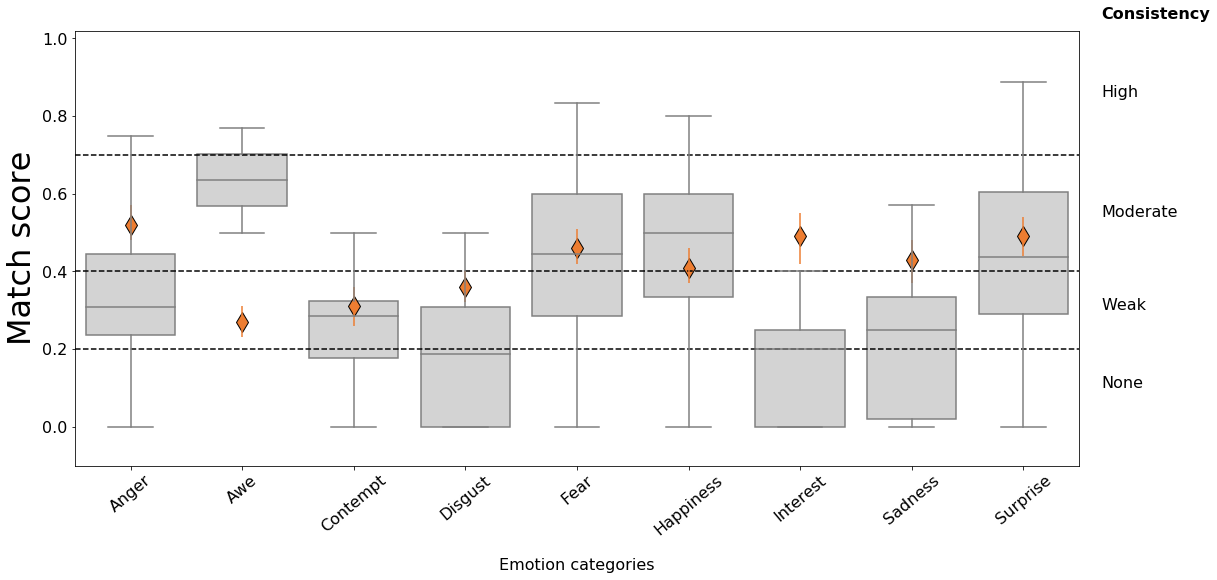

In [12]:
Plotter().plotConsistencyScore(dfs,y_axis='method1_sim_addAU')
Plotter().plotSpecificityScore(dfSpecificity,EMO_CAT_standard)

,count,mean,std,min,25%,50%,75%,max
method1_sim_addAU,90.0,0.285929,0.187233,0.0,0.153846,0.285714,0.461538,0.615385


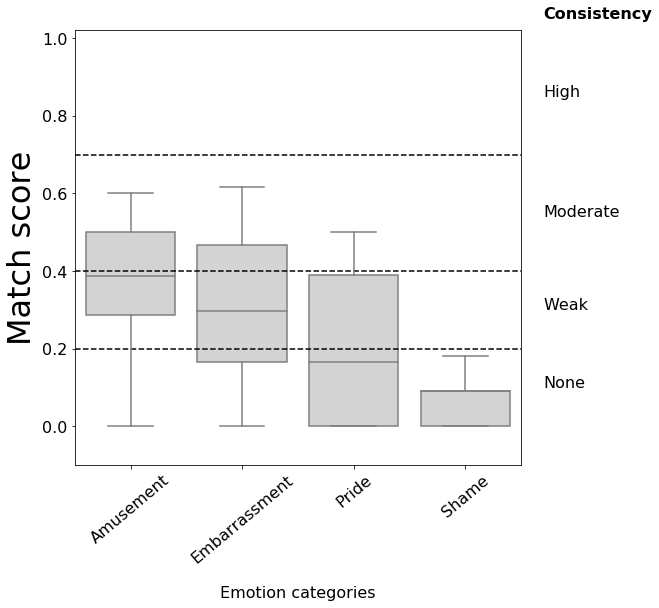

In [13]:
Plotter().plotConsistencyScore(df,y_axis='method1_sim_addAU')